# 81_PoissonRegressionSneezes

#### Tiny, and highly experimental investigation into Possion regression upon count data

      
+ [Setup](#Setup)
    + [Local Functions](#Local-Functions)


+ [Load and Describe Dataset](#Load-and-Describe-Dataset)
    + [Load Real Sneeze Data](#Load-Real-Sneeze-Data)
    + [Describe Dataset](#Describe-Dataset)


+ [Poisson Regression](#Poisson-Regression)
    + [Create Design Matrices](#Create-Design-Matrices)
    + [Create Model](#Create-Model)
    + [Sample Model](#Sample-Model)
    + [View Diagnostics and Outputs](#View-Diagnostics-and-Outputs)
    + [Observations](#Observations)


##### Package Requirements
```
$> less conda_env_pymc3_examples.yml

name: pymc3_examples
    channels:
      - defaults
    dependencies:
      - python=3.5
      - jupyter
      - numpy
      - scipy
      - matplotlib
      - pandas
      - seaborn
      - patsy  
      - pip
      - pip:
          - regex
          - Cython
          - pystan

$> conda env create --file conda_env_pymc3_examples.yml
$> source activate pymc3_examples
$> pip install --process-dependency-links git+https://github.com/pymc-devs/pymc3
```

# Setup

In [1]:
## Interactive magics
%matplotlib inline
%qtconsole --colors=linux

In [2]:
import sys
import warnings
warnings.filterwarnings('ignore')

import regex as re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import patsy as pt
from scipy import optimize

# pymc3 libraries
import pymc3 as pm
import theano as thno
import theano.tensor as T 
import pystan

sns.set(style="darkgrid", palette="muted")
pd.set_option('display.mpl_style', 'default')
plt.rcParams['figure.figsize'] = 12, 4
np.random.seed(0)

##### What versions are we running?

In [3]:
print('Python: {}'.format(sys.version))
print('Recursion limit {}'.format(sys.getrecursionlimit()))
print('theano: {}'.format(thno.__version__))
print('PyMC3: {}'.format(pm.__version__))
print('PyStan: {}'.format(pystan.__version__))

Python: 3.5.1 |Continuum Analytics, Inc.| (default, Dec  7 2015, 11:24:55) 
[GCC 4.2.1 (Apple Inc. build 5577)]
Recursion limit 10000
theano: 0.8.1
PyMC3: 3.0
PyStan: 2.9.0.0


## Local Functions

In [4]:
def strip_derived_rvs(rvs):
    '''Convenience fn: remove PyMC3-generated RVs from a list'''
    ret_rvs = []
    for rv in rvs:
        if not (re.search('_log',rv.name) or re.search('_interval',rv.name)):
            ret_rvs.append(rv)     
    return ret_rvs

def plot_traces_pymc(trcs, varnames=None):
    ''' Convenience fn: plot traces with overlaid means and values '''

    nrows = len(trcs.varnames)
    if varnames is not None:
        nrows = len(varnames)
        
    ax = pm.traceplot(trcs, varnames=varnames, figsize=(12,nrows*1.4),
                      lines={k: v['mean'] for k, v in 
                             pm.df_summary(trcs,varnames=varnames).iterrows()})

    for i, mn in enumerate(pm.df_summary(trcs, varnames=varnames)['mean']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data',
                         xytext=(5,10), textcoords='offset points', rotation=90,
                         va='bottom', fontsize='large', color='#AA0022') 

---

---

# Load and Describe Dataset

## Load Real Sneeze Data

As provided by Ian Osvald Sun 1 May 2016

In [21]:
df = pd.read_hdf('data/alcohol_medication_sneezes_by_day_1yr.hdf5')
print(df.shape)
df.head()

(335, 3)


,had_alcohol,sneezes,medication
2015-04-01,True,2.0,True
2015-04-02,False,1.0,False
2015-04-03,True,5.0,True
2015-04-04,False,1.0,False
2015-04-05,True,1.0,True


In [22]:
## quick rename to get into same format etc

df.rename(columns={'had_alcohol':'alcohol', 'sneezes':'nsneeze',
                    'medication':'meds'}, inplace=True)
# dfr['nomeds'] = ~dfr['nomeds']

In [23]:
df.groupby(['alcohol','meds']).nsneeze.mean().unstack()

meds,False,True
alcohol,,
False,0.719626,1.323529
True,1.241379,1.632353


## Describe Dataset

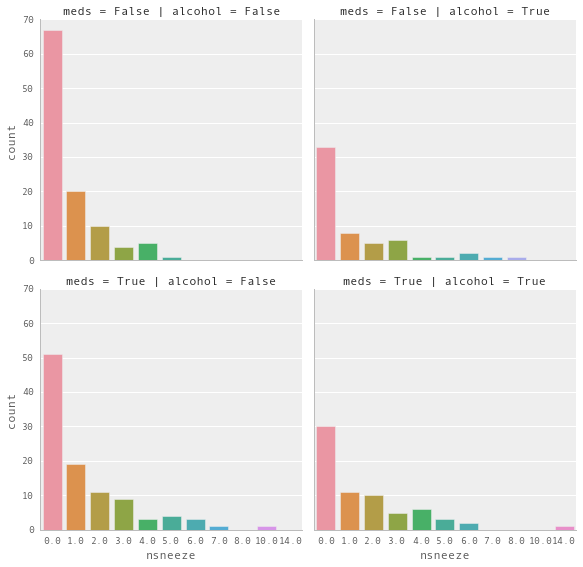

In [31]:
g = sns.factorplot(x='nsneeze', row='meds', col='alcohol', data=df,
               kind='count', size=4)

## Create design matrices

In [24]:
fml = 'nsneeze ~ alcohol * meds'  # lazy formulation
(mx_en, mx_ex) = pt.dmatrices(fml, df, return_type='dataframe', NA_action='raise')
mx_ex.head()

,Intercept,alcohol[T.True],meds[T.True],alcohol[T.True]:meds[T.True]
2015-04-01,1.0,1.0,1.0,1.0
2015-04-02,1.0,0.0,0.0,0.0
2015-04-03,1.0,1.0,1.0,1.0
2015-04-04,1.0,0.0,0.0,0.0
2015-04-05,1.0,1.0,1.0,1.0


In [25]:
mx_ex.tail()

,Intercept,alcohol[T.True],meds[T.True],alcohol[T.True]:meds[T.True]
2016-03-02,1.0,0.0,1.0,0.0
2016-03-03,1.0,0.0,0.0,0.0
2016-03-04,1.0,0.0,1.0,0.0
2016-03-05,1.0,1.0,0.0,0.0
2016-03-06,1.0,1.0,1.0,1.0


---

# Poisson Regression (PyMC3)

## Create Model (manual formulation)

In [46]:
with pm.Model() as mdl_fish:
    
    # define priors, weakly informative Normal
    b0 = pm.Normal('b0_intercept', mu=0, sd=10)
    b1 = pm.Normal('b1_alcohol[T.True]', mu=0, sd=10)
    b2 = pm.Normal('b2_meds[T.True]', mu=0, sd=10)
    b3 = pm.Normal('b3_alcohol[T.True]:meds[T.True]', mu=0, sd=10)
    
    # define linear model and exp link function
    mu = (b0 +
            b1 * mx_ex['alcohol[T.True]'] +
            b2 * mx_ex['meds[T.True]'] +
            b3 * mx_ex['alcohol[T.True]:meds[T.True]']) 

    ## Define Poisson likelihood 
    y = pm.Poisson('y', mu=np.exp(mu), observed=mx_en['nsneeze'].values)
    

## Sample Model

In [47]:
with mdl_fish:
    
    start_MAP = pm.find_MAP(fmin=optimize.fmin_powell)
    trc_fish = pm.sample(2000, start=start_MAP, njobs=2, step=pm.NUTS())

 [-----------------100%-----------------] 2000 of 2000 complete in 4.5 sec

## View diagnostics and outputs

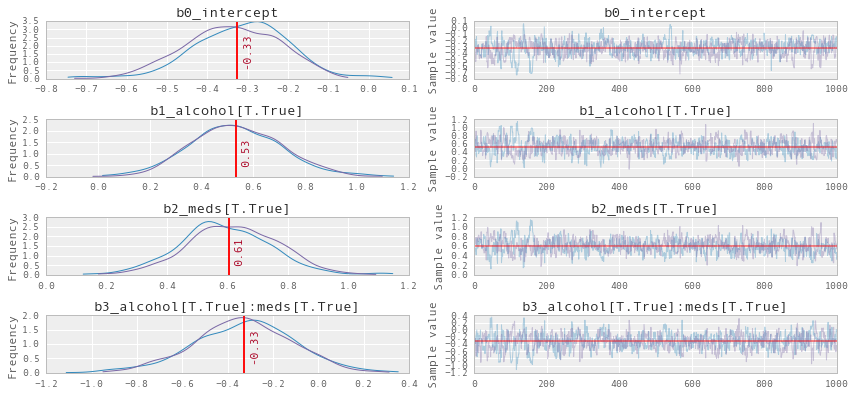

In [48]:
rvs_fish = [rv.name for rv in strip_derived_rvs(mdl_fish.unobserved_RVs)]
plot_traces_pymc(trc_fish[-1000:], varnames=rvs_fish)

##### Summary of transformed coeffs

In [50]:
np.exp(pm.df_summary(trc_fish[-1000:], varnames=rvs_fish)[['mean','hpd_2.5','hpd_97.5']])

,mean,hpd_2.5,hpd_97.5
b0_intercept,0.721192,0.574431,0.894464
b1_alcohol[T.True],1.704108,1.227426,2.410702
b2_meds[T.True],1.832044,1.342743,2.405737
b3_alcohol[T.True]:meds[T.True],0.721035,0.458757,1.080141


## Observations

+ Model converges quickly and traceplots looks pretty well mixed

+ The contributions from each feature as a multiplier of the baseline sneezecount are:
    
    
    1. exp(b0_intercept): mu=0.72, cr=[0.57, 0.89]        
    
       Sublinear baseline when no alcohol and no meds
       Which supports the distributional observation that the data looks zero-inflated


    2. exp(b1_alcohol): mu=1.70, cr=[1.22, 2.41]
    
       Small, positive-only effect of adding alcohol: a 1.70x multiplier 
       e.g. Poisson(baseline * alcohol) = 0.72 * 1.70 = Poisson(1.22)


    3. exp(b2_meds[T.True]): mu=1.83, cr=[1.34, 2.41]    
    
       Small, positive-only effect of adding meds, a 1.83x multiplier 
       e.g. Poisson(baseline * meds) = 0.72 * 1.83 = Poisson(1.31)
    
    
    4. exp(b3_alcohol[T.True]:meds[T.True]): mu=0.72, cr=[0.46, 1.08]
    
       Very small, mostly-negative interaction of alcohol and meds: a 0.72x multiplier
       i.e. the effect of alcohol and meds combined is less than you might expect
       e.g. Poisson(baseline * alcohol * meds * alcoholmeds) = 
              0.72 * 1.70 * 1.83 * 0.72 = Poisson(1.61)


+ Looks like we can state that alcohol has an independently positive-only effect on increasing sneeze count


+ Also looks like we can state that medication has an independently positive effect on increasing sneeze count. Be careful of the corrolation & causation here though, quite probably experience more sneezing thus decide to take meds


+ There appears to be a negative interaction of alcohol and medication, again though you have to be careful of the corrolation & causation. Possibly this is a good thing? Taking meds and drinking lowers the sneeze count slightly.
 
 
   
### Warning: Lots of the above contains wild hand waving YMMV

+ I've assumed a Possion model is appropriate, when quite probably the data is zero-inflated (see the b0_intercept < 1)


---
**Applied AI Ltd &copy; 2016**  
<a href='http://www.applied.ai'>applied.ai</a>